In [1]:
# Import Qiskit Library
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, SparsePauliOp
from qiskit.circuit.library import UnitaryGate  

from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import random_su4

import matplotlib.pyplot as plt
import logging
import numpy as np
import random
from tqdm.notebook import tqdm 

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

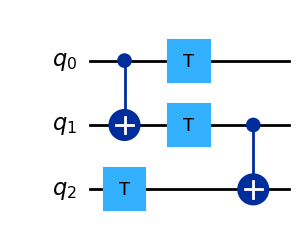

In [2]:
qc = QuantumCircuit(3, name="3-layer demo")

qc.cx(0, 1)          # Layer 1
for q in range(3):   # Layer 2
    qc.t(q)
qc.cx(1, 2)          # Layer 3

# --- draw exactly ONE figure ---
fig = qc.draw(output="mpl")   # create the figure object
plt.show()                    # display it once

In [3]:
prop   = PauliPropagator(qc)

layers = prop.propagate(PauliTerm(1.0, Pauli('IXI')), max_weight=2)   

expect = prop.expectation_pauli_sum(pauli_sum= layers[-1],
                                    product_label= "+++")   # |+⟩^{⊗3}                  
         
print(expect)

print("layer | Pauli decomposition")
for k, plist in enumerate(layers[::-1]):      
    line = "  ".join(map(str, plist))
    print(f"{k:>5} : {line}")


0.49999999999999994
layer | Pauli decomposition
    0 : +0.5,XXI  -0.5,YXI
    1 : +0.5,XXI  -0.5,XYI  -0.5,YXI  +0.5,YYI
    2 : +0.5,XXI  -0.5,XYI  -0.5,YXI  +0.5,YYI
    3 : +0.707107,XXI  -0.707107,YXI
    4 : +1,XXI
    5 : +1,IXI


In [4]:
# --- prepare |+>⊗3 as statevector ---
psi0 = Statevector.from_label("+++")

# --- evolve through the circuit ---
psi_final = psi0.evolve(qc)
# --- build X on qubit‑1 ("IXI") and compute expectation ---
obs = Pauli("IXI")
exp_val = psi_final.expectation_value(obs).real

print(f"⟨X1⟩ from statevector simulation: {exp_val:.6f}")

⟨X1⟩ from statevector simulation: 0.500000


# Above is first demo

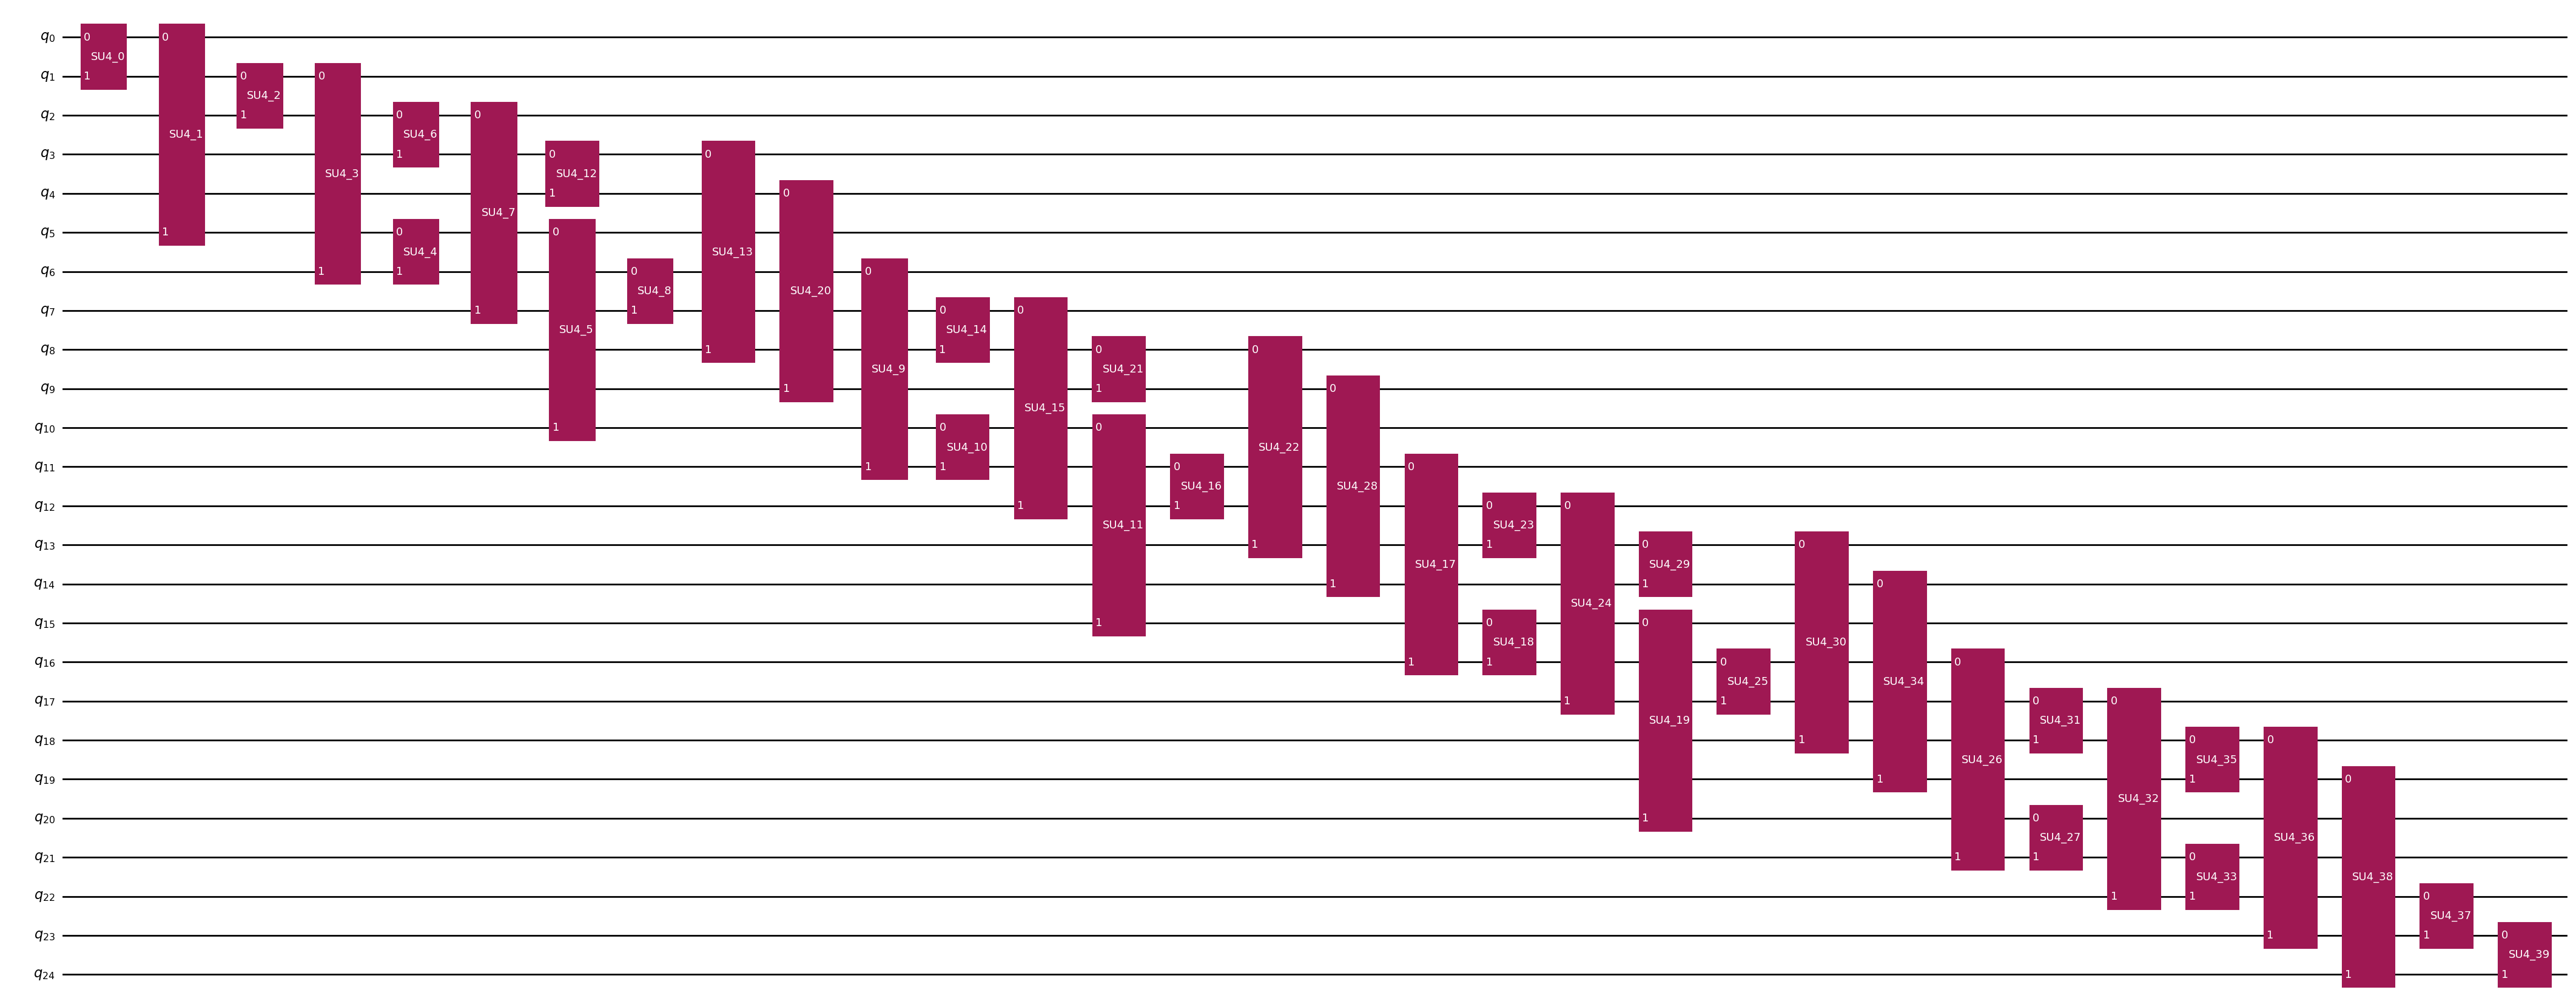

In [5]:

def _staircase_edges(nx, ny):
    """Return the ordered list of 1-based index pairs of the staircase walk."""
    next_inds, temp_inds, edges = [1], [], []
    while next_inds:
        for ind in next_inds:
            if ind % nx != 0:                      # step right
                nxt = ind + 1
                edges.append((ind, nxt)); temp_inds.append(nxt)
            if ((ind-1)//nx + 1) < ny:             # step down
                nxt = ind + nx
                edges.append((ind, nxt)); temp_inds.append(nxt)
        next_inds, temp_inds = temp_inds, []
    seen, uniq = set(), []
    for e in edges:                                # preserve order, dedup
        if e not in seen:
            seen.add(e); uniq.append(e)
    return uniq

def staircasetopology2d_qc(nx, ny):
    """
    Build a QuantumCircuit that places a fresh SU(4) gate on every edge
    of the 2-D staircase topology for an nx × ny grid (row-major indexing).
    """
    nqubits = nx * ny
    qc = QuantumCircuit(nqubits)
    for k, (q1, q2) in enumerate(_staircase_edges(nx, ny)):  # 1-based
        mat = random_su4()
        gate = UnitaryGate(mat, label=f"SU4_{k}")   # create the gate
        gate._name = "su4"                          # override its name
        qc.append(gate, [q1-1, q2-1])               # 0-based
    return qc

# Example usage:
nx, ny = 5,5
qc_2d = staircasetopology2d_qc(nx, ny)

fig = qc_2d.draw(output="mpl", fold=-1)   # no line-wrapping
plt.show()

In [6]:
n = qc_2d.num_qubits # Here n is number of qubit in 2d circuit

plus_label = "+" * n # build a string of "+" of length n, e.g. "+++++"

# ─── Build the single-qubit X observable on qubit 0 ───────────────────────────
pauli_label = "X" + "I" * (n - 1) # For X on qubit 0 and Identity elsewhere, we need "X" + "I"*(n-1)
obs = Pauli(pauli_label)

# ─── Evolve the statevector through the 2D staircase circuit ─────────────────
psi0 = Statevector.from_label(plus_label)
psi_final = psi0.evolve(qc_2d)

# ─── Compute and print the expectation value ───────────────────────────────────
exp_val = psi_final.expectation_value(obs).real
print(f"⟨X on qubit 0⟩ from statevector simulation: {exp_val:.6f}")

⟨X on qubit 0⟩ from statevector simulation: -0.054634


In [7]:
# 25 qubit, 1 layer, weight 3, 1min1s
# 36 qubit, 1 layer, weight 3, takes 3min46s, 

In [8]:
prop_2d   = PauliPropagator(qc_2d)
print('1')
layers_2d = prop_2d.propagate(PauliTerm(1.0, Pauli(pauli_label)), max_weight = 3)   
print('2')
expect_2d = prop_2d.expectation_pauli_sum(pauli_sum= layers_2d[-1],
                                    product_label= plus_label)   # |+⟩^{⊗n}                  
print('3')
print(expect_2d)

1
2
3
-0.043971192707266606


In [9]:
# after passing all test, play with truncation
# implement more gates (should be fully compatble with qiskit)
# compare simulation with tensor network, quimb
# play with circuit people considered(portfolio optimisaiton)

In [10]:
# 写test suite
# 和state vector方法对比性能
# implement更多门
# QuantumGate.get(instr.operation.name)

# 知道电路在很多observable下的expectation不就行了嘛？为什么还要费劲巴拉地做simulation?

# 还是不太理解_cx_rule和_t_rule的具体实现，给我例子说明具体实现

# 没见过这种语法：bucket: defaultdict[str, complex] = defaultdict(complex)


# 还是不理解merge_like_terms的具体实现，给例子

# _cx_rule 以及 PauliPropagation” 的设计思路有帮助。它们一起完成“在泡利基中对可观测量做非 Clifford 演化并在重量上进行截断”的功能。


#     @classmethod
#     def register(cls, name: str):
#         """Decorator: register a new rule under *name* and
#         attach it as <NAME>gate attribute for convenience."""
#         def wrapper(func: Callable):
#             cls._registry[name] = func
#             setattr(cls, f"{name.upper()}gate", staticmethod(func))
#             return staticmethod(func)
#         return wrapper
